In [1]:
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import random
import numpy as np

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel, ldamodel

from topic_modeler import TopicModeler

random.seed(123)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Table of Contents

* [Model Search (LDA)](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Model-Search-(LDA))
    * [Begin with a small corpus, and unigrams](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Begin-with-a-small-corpus,-and-unigrams)
    * [Compare to n-grams (small corpus)](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Compare-to-ngrams-(small-dataset))
    * [Increase size of corpus used for fitting](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Increase-the-size-of-the-corpus-used-for-fitting)
* [Explore selected model](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Explore-selected-model)
    * [Visualization](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Visualization)
* [Conclusion of LDA Exploration](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Conclusion-of-LDA-exploration)
* [Write Results](http://localhost:8888/notebooks/arxiv/topic_model_search.ipynb#Write-results)

# Model Search (LDA)

## Begin with a small corpus, and unigrams

To start with, we will explore fitting latent dirichlet allocation on a small dataset. Later, we'll fit the models on larger datasets and compare the coherence.

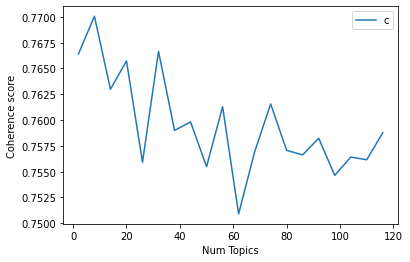

In [2]:
mod = TopicModeler('preprocessed_input/preprocessed_input_small_unigrams.json')
mod.set_texts()
mod.set_dictionary()
mod.set_corpus()

start = 2; stop = 120; step = 6; iterations=300
model_list, coherence_values = mod.optimal_model_search(start, stop, step, iterations)

mod.plot_model_search_results(coherence_values, start, stop, step)

Optimal coherence is found with 2 topics. After 2 topics, the coherence varies a bit but is generally trending downward with the number of topics.

## Compare to ngrams (small dataset)

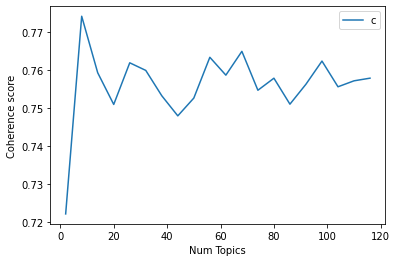

In [3]:
model_list, coherence_values = mod.optimal_model_search(start,stop,step,iterations=300)

mod.plot_model_search_results(coherence_values, start, stop, step)

This is an interesting result; overall, the models are not necessarily an improvement, but we see in the n-gram model that models with a relatively large number of topics have pretty good coherence. 

With the n-gram model in particular, the fact that we are using a smaller dataset (only  approx. 100 documents) is probably making things more difficult. We'll next run the model search process on a much larger dataset (approx. 10k documents) and compare.

## Increase the size of the corpus used for fitting

Next, we re-fit the unigram and ngrams models on a larger dataset.

Results of model search on unigrams:


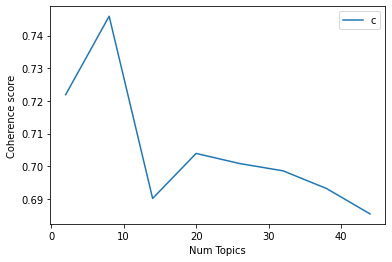

Results of model search on ngrams:


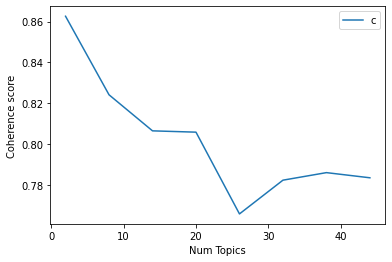

In [4]:
mod1 = TopicModeler('preprocessed_input/preprocessed_input_unigrams.json')
mod1.set_texts()
mod1.set_dictionary()
mod1.set_corpus()

start = 2; stop=50; step=6
np.random.seed(12345)
model_list_unigrams, coherence_values = mod1.optimal_model_search(start,stop,step,iterations=100)

print('Results of model search on unigrams:')
mod1.plot_model_search_results(coherence_values, start, stop, step)

mod2 = TopicModeler('preprocessed_input/preprocessed_input_ngrams.json')
mod2.set_texts()
mod2.set_dictionary()
mod2.set_corpus()

np.random.seed(12345)
model_list_ngrams, coherence_values = mod2.optimal_model_search(start,stop,step,iterations=100)
print('Results of model search on ngrams:')
mod2.plot_model_search_results(coherence_values, start, stop, step)

A few observiations:

    1) Coherence is significantly improved overall.
    2) We now see that models fit to the n-grams dataset have significantly better coherence than models fit to the unigrams dataset.
    3) We still find that models with a relatively small number of topics have better coherence. With n-gram models, the decrease in coherence is more linear while in the unigram models, there is a sharp dropoff. This results in findings such as "a n-gram model with 30 topics has significantly better coherence than a unigram model with 10 topics."
    
It is not exactly clear from the coherence values alone which number of topics will be best for our purposes. While a n-grams model with 2 topics has optimal coherence, seperating the dataset into only two topics is not so useful. We'll have to explore the models a bit more before making a choice.

# Explore selected model

### Summary of unigrams model

In [5]:
print('Eight topic unigram-based model:')
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

Eight topic unigram-based model:


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"ccpm, offer, replenish, kinematic, israel, achievable, tabulation, credence, identically, ibex",951,0.0954
1,1.0,"marginalization, mmv, assortative, lie, sdma, cbj, homological, munich, ivoting, quantal",1281,0.1285
2,2.0,"hostile, meticulous, remnant, powerpoint, pioneering, customise, managerial, delineated, rademacher, loss",757,0.0759
3,3.0,"rbpf, compressor, b, efs, wordnetdomains, devices, sumo, closely, radon, restoring",1165,0.1169
4,4.0,"capitalize, rho, rugby, slider, orbits, acceptability, reproducible, specifie, ink, kings",1397,0.1401
5,5.0,"val, trials, apps, guidelines, apprentissage, prototypical, community, prerequisite, uninstantiated, disturbance",834,0.0837
6,6.0,"rbf, brazil, nongenetic, prm, exotic, aplicados, nutritional, varying, fungal, blackboxe",1276,0.1280
7,7.0,"metering, mml, huaren, connectedness, palette, binarize, wsd, alphabetically, nonmonotonicity, rationality",2307,0.2314


### Summary of ngrams model:

In [6]:
print('Two topic ngram based model:')
mod2.set_optimal_model(model_list_ngrams, 0)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(2)

Two topic ngram based model:


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"real life temporal scenarios, cumulative path, precise sense, Machine Learning Perspective, chosen path, distributed asynchronous manner, original MART, astrobiological interest, fuzzy filter, news portals",6268,0.6288
1,1.0,"fuzzy theory, traditional SDAs, unabashed speculation, second popular distance function, general submodular minimization, representational support, simple Perceptron algorithm, maximal tractable subclasses, reward model Markovian reward model, known inference procedures",3700,0.3712


In [7]:
print('Eight topics ngram based model:')
mod2.set_optimal_model(model_list_ngrams, 1)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

Eight topics ngram based model:


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"tractable convex program, optimization engine, life archival purposes, Infinite classes, unlabeled documents, database similarity search, natural language comprehension generation system, descriptive analysis, RDP histograms, networked organization",1730,0.1736
1,1.0,"arbitrary pairwise similarity measures, Lagrangian positions, causally sound plot progression, problem solving facilities, redundant rules, network anomaly detection, Diesel Engine, possibly infinite family, thematic propositions, soft computing method",1452,0.1457
2,2.0,"slightly restricted form, automat, GPS Pseudorange Based Cooperative Vehicular Distance Measurement, D chart, heuristic nature, useful prototyping tool, Follow Perturbed Leader algorithms, variational lower bound yields, feedback delay, given graded modal logic formula",1295,0.1299
3,3.0,"algorithm properties, single edge graphs, WTA fixed point, neuro linguistic processing, local nature, high probability, StructBoost, rule based inference systems, present experimental work, method outperform",840,0.0843
4,4.0,"new visualization software Pajek, environment dynamics, additionally objects, tailored Particle Markov Chain Monte Carlo samplers, high interest, Bayesian similarity measure, initial condition, online convex optimization algorithms, clinicopathological conference, connected matroids",1200,0.1204
5,5.0,"Argumentative inference, presumably complete mathematical theory, consistent way, exponential rate, Littlewood Offord lemma, Outcome Type variable, Immune System, conventional recommender systems, SVRG method, sampling process",1167,0.1171
6,6.0,"Modelling Concurrent Behaviors, comprehensive framework, correct derivatives, Special focus, algorithm implementations, tags p, certain prototypical patterns, comprehensive algorithmic derivation, transport contract, expert utility function",1263,0.1267
7,7.0,"intruders, Manhattan Non negative Matrix Factorization, low resolution CCTV probe images, worker nodes, weighted expert voting, practical interest calls, ALDP, baseline approach, sparse model, consistent conceptual design solutions",1021,0.1024


## Visualization

In [8]:
mod1.set_optimal_model(model_list_unigrams, 1)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)
topic_summary_df.head(8)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod1.model, mod1.corpus, mod1.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.000859 -0.000359       1        1  21.945187
4      0.000209 -0.000408       2        1  14.653732
6     -0.000566  0.000789       3        1  13.056495
1      0.000108  0.000300       4        1  12.989190
3     -0.000723 -0.000285       5        1  11.620687
0     -0.000139 -0.000483       6        1   9.584930
5      0.000557  0.000778       7        1   8.242726
2     -0.000306 -0.000332       8        1   7.907054, topic_info=               Term       Freq      Total Category  logprob  loglift
12856  phonetically  40.000000  40.000000  Default  30.0000  30.0000
949        addition  39.000000  39.000000  Default  29.0000  29.0000
3626    reliability  39.000000  39.000000  Default  28.0000  28.0000
21317      launched  39.000000  39.000000  Default  27.0000  27.0000
20956    meticulous  39.000000  39.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
7137       schipper   4.210749  43.593615   Topic8  -9.7374   0.2001
661    significance   4.215933  44.498105   Topic8  -9.7361   0.1808
7458         analog   4.204526  44.138322   Topic8  -9.7388   0.1862
16294    undeserved   4.182616  42.615534   Topic8  -9.7441   0.2161
3791        underly   4.176523  42.377034   Topic8  -9.7455   0.2203

[401 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
12069      1  0.199979  acceptability
12069      2  0.177759  acceptability
12069      3  0.111099  acceptability
12069      4  0.111099  acceptability
12069      5  0.133319  acceptability
...      ...       ...            ...
5872       4  0.125509          xmlkr
5872       5  0.150611          xmlkr
5872       6  0.100407          xmlkr
5872       7  0.075305          xmlkr
5872       8  0.075305          xmlkr

[3080 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 7, 2, 4, 1, 6, 3])

In [9]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod2.model, mod2.corpus, mod2.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000180  0.000132       1        1  17.001503
1      0.000150 -0.000943       2        1  14.511484
6     -0.000522  0.000329       3        1  13.060970
2      0.001217  0.000253       4        1  13.033199
4     -0.000024 -0.000216       5        1  12.284330
5     -0.000252 -0.000382       6        1  11.559556
7     -0.000300 -0.000006       7        1  10.074706
3     -0.000089  0.000833       8        1   8.474252, topic_info=                                 Term      Freq     Total Category  logprob  \
106712  Expert Classification Systems  2.000000  2.000000  Default  30.0000   
18182                 different parts  2.000000  2.000000  Default  29.0000   
35759                Association Rule  2.000000  2.000000  Default  28.0000   
79874                         Scrapie  2.000000  2.000000  Default  27.0000   
72735              additive phenomena  2.000000  2.000000  Default  26.0000   
...                               ...       ...       ...      ...      ...   
102487                  Sensitivities  0.312363  2.825764   Topic8 -11.5492   
137352                       ARPlaces  0.313566  2.945516   Topic8 -11.5453   
13888                 historical maps  0.312171  2.860022   Topic8 -11.5498   
131689           initial seed patches  0.312567  2.905129   Topic8 -11.5485   
8447                 high performance  0.312542  3.002038   Topic8 -11.5486   

        loglift  
106712  30.0000  
18182   29.0000  
35759   28.0000  
79874   27.0000  
72735   26.0000  
...         ...  
102487   0.2658  
137352   0.2281  
13888    0.2531  
131689   0.2387  
8447     0.2058  

[433 rows x 6 columns], token_table=        Topic      Freq                              Term
term                                                     
137352      1  0.339499                          ARPlaces
137323      1  0.341883  American style crossword puzzles
105160      1  0.311359           Argumentative inference
105160      6  0.311359           Argumentative inference
40192       1  0.341078                       BN dynamics
...       ...       ...                               ...
18518       2  0.350228             varying Poisson model
102939      2  0.377533                visual uncertainty
130101      1  0.329449            weighted expert voting
93342       1  0.358769                      worker nodes
72145       1  0.344900                  zero constraints

[165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 7, 3, 5, 6, 8, 4])

# Conclusion of LDA exploration

The ngram model, despite having a greater coherence metric, is seperating topics based on very specific technical terms found in the arXiv dataset. We see in visualization that virually all of the terms appper only once or twice in the corpus. In the bubble plot, we see that there is not great seperation between topics; it appears that maybe 3 topics would be the best model (2, 3, and 8). It looks like we can also reduce the number of topics in the unigram model (which we already knew from the coherence plot, but is confirmed in the bubble plot).

In all cases, the topics are not very human interpretable. This may not be too surprising; as put in a Stack Overflow post:

<blockquote>"LDA's "topics" are a mathematical construct and you shouldn't confuse them with actual human topics. You can end up with topics that have no human interpretation -- they're more like artifacts of the process than actual topics -- and you can end up with topics at different levels of abstraction, including topics that basically cover the same human topic. It's a bit like reading tea leaves."
LDA vs word2vec, URL (version: 2019-02-20): https://stats.stackexchange.com/q/393447</blockquote>

Below, we run a final search over a finer-gained range that covers models with a small number of topics (2 through 7).

Results of model search on unigrams:


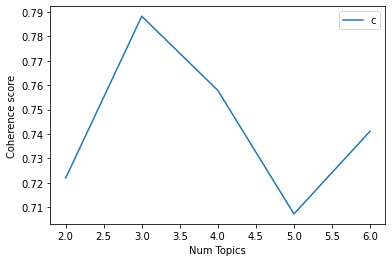

Results of model search on ngrams:


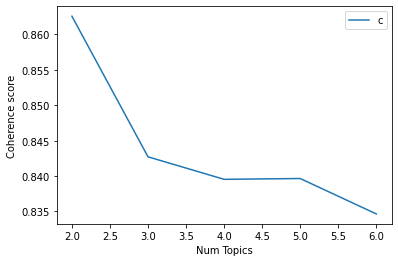

In [10]:
mod1 = TopicModeler('preprocessed_input/preprocessed_input_unigrams.json')
mod1.set_texts()
mod1.set_dictionary()
mod1.set_corpus()

start = 2; stop=7; step=1
np.random.seed(12345)
model_list_unigrams, coherence_values = mod1.optimal_model_search(start,stop,step,iterations=300)

print('Results of model search on unigrams:')
mod1.plot_model_search_results(coherence_values, start, stop, step)

mod2 = TopicModeler('preprocessed_input/preprocessed_input_ngrams.json')
mod2.set_texts()
mod2.set_dictionary()
mod2.set_corpus()

np.random.seed(12345)
model_list_ngrams, coherence_values = mod2.optimal_model_search(start,stop,step,iterations=00)
print('Results of model search on ngrams:')
mod2.plot_model_search_results(coherence_values, start, stop, step)

In [19]:
mod1.set_optimal_model(model_list_unigrams, 3)
sent_topics_df, doc_topic_summary = mod1.produce_doc_topic_summary_df()
topic_summary_df = mod1.produce_topic_summary_df(sent_topics_df)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod1.model, mod1.corpus, mod1.dictionary)
viz

/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/mdinauta/v-envs/tip/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=                  x         y  topics  cluster       Freq
topic                                                    
1      1.488103e-04  0.000223       1        1  32.407519
0     -1.043938e-03 -0.000286       2        1  25.518492
4      3.535258e-04 -0.000706       3        1  20.615684
2      5.407380e-04 -0.000153       4        1  11.737407
3      8.636894e-07  0.000921       5        1   9.720899, topic_info=               Term       Freq      Total Category  logprob  loglift
3079       somewhat  42.000000  42.000000  Default  30.0000  30.0000
12415  pathologique  40.000000  40.000000  Default  29.0000  29.0000
20300         godec  40.000000  40.000000  Default  28.0000  28.0000
8568   confidential  40.000000  40.000000  Default  27.0000  27.0000
16887    couterpart  42.000000  42.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
14172          webb   5.099745  43.522136   Topic5  -9.7523   0.1868
8786           cent   5.096663  43.661614   Topic5  -9.7529   0.1830
12677          nlpm   5.091781  44.604694   Topic5  -9.7539   0.1607
7036       mycology   5.078913  43.629891   Topic5  -9.7564   0.1802
10216   bradfordize   5.070804  42.464548   Topic5  -9.7580   0.2057

[296 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1685      1  0.331616  acm
1685      2  0.243185  acm
1685      3  0.243185  acm
1685      4  0.088431  acm
1685      5  0.088431  acm
...     ...       ...  ...
6941      1  0.273235  wsd
6941      2  0.294253  wsd
6941      3  0.210181  wsd
6941      4  0.126109  wsd
6941      5  0.084072  wsd

[1410 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 3, 4])

In [20]:
print('Portion of document topic matrix:')
doc_topic_matrix = mod1.produce_doc_topic_matrix()
doc_topic_matrix.head(10)

Portion of document topic matrix:


,0,1,2,3,4
0,0.992872,0.000000,0.0,0.0,0.0
1,0.991386,0.000000,0.0,0.0,0.0
2,0.987282,0.000000,0.0,0.0,0.0
3,0.989399,0.000000,0.0,0.0,0.0
4,0.648610,0.347392,0.0,0.0,0.0
5,0.273083,0.719060,0.0,0.0,0.0
6,0.994628,0.000000,0.0,0.0,0.0
7,0.258973,0.734210,0.0,0.0,0.0
8,0.986871,0.000000,0.0,0.0,0.0
9,0.893313,0.101723,0.0,0.0,0.0


In [13]:
mod2.set_optimal_model(model_list_ngrams, 3)
sent_topics_df, doc_topic_summary = mod2.produce_doc_topic_summary_df()
topic_summary_df = mod2.produce_topic_summary_df(sent_topics_df)

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim_models.prepare(mod2.model, mod2.corpus, mod2.dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.001023 -0.000382       1        1  20.035978
4      0.000296  0.000392       2        1  20.022532
1     -0.000101  0.000853       3        1  19.986544
0      0.000283 -0.000189       4        1  19.984533
3      0.000545 -0.000673       5        1  19.970413, topic_info=                                    Term      Freq     Total Category  \
75055             dynamic pricing policy  2.000000  2.000000  Default   
109735  low resolution CCTV probe images  2.000000  2.000000  Default   
44190                            para NP  2.000000  2.000000  Default   
76786     nonlinearity log linear models  2.000000  2.000000  Default   
28535                          intruders  2.000000  2.000000  Default   
...                                  ...       ...       ...      ...   
62103                         action set  0.724689  2.953052   Topic5   
31918                       redundancies  0.724142  2.943656   Topic5   
41335    exact reconstruction guarantees  0.722797  2.917955   Topic5   
1917                                task  0.727612  3.073467   Topic5   
9532                          impression  0.725396  3.005907   Topic5   

        logprob  loglift  
75055   30.0000  30.0000  
109735  29.0000  29.0000  
44190   28.0000  28.0000  
76786   27.0000  27.0000  
28535   26.0000  26.0000  
...         ...      ...  
62103  -11.5648   0.2061  
31918  -11.5656   0.2085  
41335  -11.5674   0.2154  
1917   -11.5608   0.1701  
9532   -11.5638   0.1893  

[302 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
110624      1  0.339398          ALDP
110624      2  0.339398          ALDP
110624      3  0.339398          ALDP
110624      4  0.339398          ALDP
110624      5  0.339398          ALDP
...       ...       ...           ...
93342       1  0.339502  worker nodes
93342       2  0.339502  worker nodes
93342       3  0.339502  worker nodes
93342       4  0.339502  worker nodes
93342       5  0.339502  worker nodes

[1067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [16]:
print('Portion of document topic matrix:')
doc_topic_matrix = mod2.produce_doc_topic_matrix()
doc_topic_matrix.head(10)

Portion of document topic matrix:


,0,1,2,3,4
0,0.182689,0.202578,0.217405,0.186122,0.211206
1,0.188105,0.202205,0.173969,0.223592,0.212129
2,0.216245,0.213620,0.205896,0.195440,0.168799
3,0.194462,0.225349,0.172920,0.187854,0.219415
4,0.207435,0.215956,0.184388,0.189361,0.202860
5,0.223302,0.182319,0.189646,0.214030,0.190703
6,0.212943,0.170563,0.196665,0.203321,0.216509
7,0.193417,0.213991,0.222871,0.184721,0.184999
8,0.187779,0.236172,0.169535,0.192974,0.213541
9,0.212818,0.189274,0.175938,0.214112,0.207858


The seperation is better in these models. An interesting observation is that the probabilities that a given topic belongs to a given topic are generally much higher in the unigram-based model; this is not obvious from the bubble plot alone but is observed in the tables.

To achive a mix of decent seperation and coherence and also a relatively large number of topics to make the applicate interesting/useful (i.e. more than 2 or 3), we'll will choice the unigram-based model with 5 topics as our final model. Although the coherence is technical a bit lower than in the ngram models, it seems more human-interpretable. 

# Write results

In [34]:
# get most representive documents for each topic, ranked
mod1.set_optimal_model(model_list_unigrams, 3)
doc_topic_matrix = mod1.produce_doc_topic_matrix()

collect_rankings = pd.DataFrame()
collect_rankings['Topic_1'] = doc_topic_matrix.sort_values(0, ascending=False).index
collect_rankings['Topic_2'] = doc_topic_matrix.sort_values(1, ascending=False).index
collect_rankings['Topic_3'] = doc_topic_matrix.sort_values(2, ascending=False).index
collect_rankings['Topic_4'] = doc_topic_matrix.sort_values(3, ascending=False).index
collect_rankings['Topic_5'] = doc_topic_matrix.sort_values(4, ascending=False).index

collect_rankings.to_csv('output/document_indices_ranked.csv', index=False)